<a href="https://colab.research.google.com/github/aulphin/Focus_Shifting_atk_exp/blob/main/Try__graph_GuISE_FS_atk_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trying for original rise+fs attack and doing GuISE

Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FS_Attack-main

/content/drive/MyDrive/FS_Attack-main


Importing Libraries

In [ ]:
from collections import defaultdict
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import torch
from skimage.transform import resize
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

Input Img Process

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the image
image_path = 'tmp_image/11.jpeg'

In [ ]:
image = Image.open(image_path).convert('RGB')

# Preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(image).to(device)

In [ ]:
# Keep a copy of the original image tensor if needed
original_img = img_tensor.clone()

In [ ]:
# Convert tensor to NumPy array for SLIC (move to CPU, then transpose)
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)  # Shape: [224, 224, 3]
print("Original image shape:", img_np.shape)

Original image shape: (224, 224, 3)


Generate Guided mask

In [ ]:
print("Original image shape:", img_np.shape)


Original image shape: (224, 224, 3)


In [ ]:
from skimage.segmentation import slic
# Apply SLIC with an appropriate number of segments
n_segments = img_np.shape[0] * img_np.shape[1] // 256
n_segments

segments_slice = slic(img_np, n_segments=n_segments, compactness=10, sigma=1)
segments_slice.shape


(224, 224)

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
from skimage.color import rgb2gray
from skfuzzy.cluster import cmeans

# Convert image to grayscale and reshape for clustering
gray = rgb2gray(img_np)
data = gray.ravel().reshape(1, -1)  # Shape (1, N) for cmeans

# Fuzzy C-Means clustering
cntr, u, _, _, _, _, _ = cmeans(data, c=3, m=2, error=0.005, maxiter=1000)

# Get crisp labels and reshape to original image shape
labels = np.argmax(u, axis=0).reshape(gray.shape)

print("Unique clusters from Fuzzy c-Means:", np.unique(labels))


Unique clusters from Fuzzy c-Means: [0 1 2]


In [ ]:
# Define number of clusters
k = 3

Assigning clusters to each segment

Number of segments: 176
Unique assigned clusters: [0 1 2]


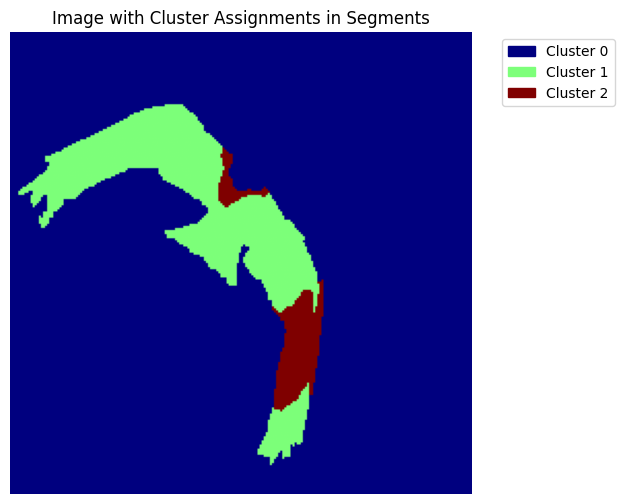

Final unique values in clustered image: [0 1 2]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import matplotlib.patches as mpatches

# Assign each segment the most frequent (mode) cluster label
segment_ids = np.unique(segments_slice)
segment_clusters = {
    seg_id: int(mode(labels[segments_slice == seg_id], axis=None).mode)
    for seg_id in segment_ids
}

# Map cluster assignments to a segment-wise image
clustered_segments_img = np.vectorize(segment_clusters.get)(segments_slice)

# Print summary
print(f"Number of segments: {len(segment_ids)}")
print("Unique assigned clusters:", np.unique(list(segment_clusters.values())))

# Visualize clustered segments
cmap = plt.cm.jet
norm = plt.Normalize(vmin=clustered_segments_img.min(), vmax=clustered_segments_img.max())
unique_clusters = np.unique(clustered_segments_img)
colors = [cmap(norm(c)) for c in unique_clusters]
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {int(c)}') for i, c in enumerate(unique_clusters)]

plt.figure(figsize=(6, 6))
plt.imshow(clustered_segments_img, cmap=cmap)
plt.title("Image with Cluster Assignments in Segments")
plt.axis('off')
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# Final check
print("Final unique values in clustered image:", np.unique(clustered_segments_img))


Histogram Implementation

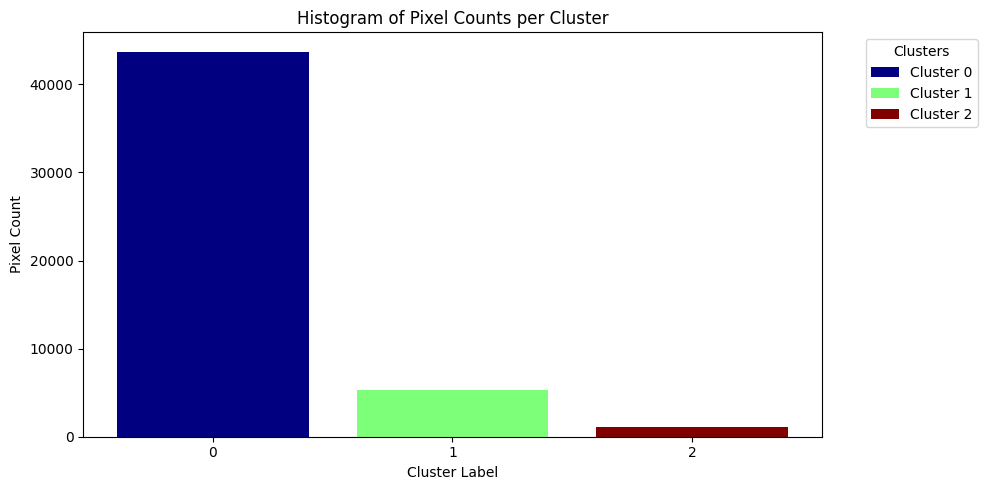

In [ ]:
# Count pixels per cluster
cluster_pixel_counts = np.bincount(clustered_segments_img.flatten(), minlength=k)

# Plot histogram
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(range(k), cluster_pixel_counts, color=colors)

# Axis labeling and title
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Pixel Count')
ax.set_title('Histogram of Pixel Counts per Cluster')
ax.set_xticks(range(k))

# Add color legend
ax.legend(bars, [f'Cluster {i}' for i in range(k)], title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Total number of pixels in the image
total_pixels = original_img.shape[0] * original_img.shape[1]

# Compute cluster percentages
cluster_percentages = (cluster_pixel_counts / total_pixels) * 100

# Normalize and round percentages
normalized_percentages = np.round(cluster_percentages * (100 / cluster_percentages.sum()), 2)

# Ensure the total is exactly 100%
difference = 100 - normalized_percentages.sum()
if difference != 0:
    normalized_percentages[-1] += difference

print("Cluster percentage distribution:", normalized_percentages)


Cluster percentage distribution: [87.12 10.6   2.28]


In [ ]:
# #### New Computation ############3

out =(normalized_percentages / 100)
prob = (1-out)
probabilities = np.where(out > 0.2, 0.5, np.round(prob, 2))
print(probabilities)


[0.5  0.89 0.98]


In [ ]:
# cluster labels as keys and probabilities as values
cluster_probability_dict = {cluster_label: probability for cluster_label, probability in zip(range(0, k+1 ), probabilities)}

#Create the  formatted
cluster_probability = {"cluster " + str(cluster_label): probability for cluster_label, probability in cluster_probability_dict.items()}

# Print the result
print(cluster_probability)


{'cluster 0': np.float64(0.5), 'cluster 1': np.float64(0.89), 'cluster 2': np.float64(0.98)}


In [ ]:
#kvalue
k= 3
clusters = clustered_segments_img
# Define probabilities for each cluster
probabilities = cluster_probability
print(probabilities)
print(clusters.shape)

{'cluster 0': np.float64(0.5), 'cluster 1': np.float64(0.89), 'cluster 2': np.float64(0.98)}
(224, 224)


In [ ]:
# import numpy as np
# from scipy.stats import mode
# import random

# def generate_segment_masks(clusters, segments, probabilities):
#     unique_segments = np.unique(segments)
#     segment_clusters = {}

#     # Assign the mode cluster to each segment
#     for segment in unique_segments:
#         mask = (segments == segment)
#         cluster_ids = clusters[mask]
#         mode_cluster = mode(cluster_ids, keepdims=False).mode
#         if mode_cluster.size > 0:
#             segment_clusters[segment] = int(mode_cluster)

#     # Count how many segments are in each cluster
#     from collections import defaultdict
#     cluster_to_segments = defaultdict(list)
#     for segment, cluster_id in segment_clusters.items():
#         cluster_to_segments[cluster_id].append(segment)

#     # Create the binary mask
#     final_mask = np.zeros_like(segments, dtype=float)

#     for cluster_id, segment_list in cluster_to_segments.items():
#         cluster_key = f'cluster {cluster_id}'
#         if cluster_key in probabilities:
#             num_select = int(probabilities[cluster_key] * len(segment_list))
#             selected_segments = random.sample(segment_list, min(num_select, len(segment_list)))
#             for segment in selected_segments:
#                 final_mask[segments == segment] = 1

#     return final_mask


In [ ]:
import torch
from scipy.stats import mode  # Still used here for mode computation
import random
from collections import defaultdict

def generate_segment_masks(clusters, segments, probabilities):
    unique_segments = torch.unique(segments)
    segment_clusters = {}

    # Assign the mode cluster to each segment
    for segment in unique_segments:
        mask = (segments == segment)
        cluster_ids = clusters[mask]

        # Convert to CPU for scipy mode (since PyTorch doesn't support mode with frequency)
        cluster_ids_np = cluster_ids.cpu().numpy()
        mode_cluster = mode(cluster_ids_np, keepdims=False).mode
        if mode_cluster.size > 0:
            segment_clusters[int(segment)] = int(mode_cluster)

    # Count how many segments are in each cluster
    cluster_to_segments = defaultdict(list)
    for segment, cluster_id in segment_clusters.items():
        cluster_to_segments[cluster_id].append(segment)

    # Create the binary mask (same shape as segments)
    final_mask = torch.zeros_like(segments, dtype=torch.float32)

    for cluster_id, segment_list in cluster_to_segments.items():
        cluster_key = f'cluster {cluster_id}'
        if cluster_key in probabilities:
            num_select = int(probabilities[cluster_key] * len(segment_list))
            selected_segments = random.sample(segment_list, min(num_select, len(segment_list)))
            for segment in selected_segments:
                final_mask[segments == segment] = 1.0

    return final_mask


In [ ]:
# result_masks = generate_segment_masks(labels, segments_slice, probabilities)
# # No of mask
# N=256
# masks = np.array([generate_segment_masks(labels, segments_slice, probabilities) for _ in range(N)])
# print(masks.shape)

In [ ]:
# Convert everything to PyTorch tensors (if needed)
labels_tensor = torch.from_numpy(labels).to(torch.int64).to(device) if isinstance(labels, np.ndarray) else labels
segments_tensor = torch.from_numpy(segments_slice).to(torch.int64).to(device)

# Now use these tensors
result_mask = generate_segment_masks(labels_tensor, segments_tensor, probabilities)


In [ ]:
# Generate N masks
N = 256
masks = torch.stack([
    generate_segment_masks(labels_tensor, segments_tensor, probabilities)
    for _ in range(N)
])

print(masks.shape)  # Expected: [N, H, W]

torch.Size([256, 224, 224])


Pre-trained Resnet-50 Model

In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import models

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.model = models.resnet50(weights='DEFAULT')
#         self.model.eval()
#         self.input_size = (224, 224)

#     def forward(self, x):
#         return self.model(x)

#     def run_on_batch(self, x_np):
#         """
#         x_np: numpy array of shape [N, H, W, C], values in [0, 255] or [0, 1]
#         """
#         with torch.no_grad():
#             x_tensor = torch.tensor(x_np).permute(0, 3, 1, 2).float()
#             x_tensor = x_tensor.to(next(self.model.parameters()).device)
#             output = self.model(x_tensor)
#             return output.cpu().numpy()

#     def classify(self, x):
#         with torch.no_grad():
#             preds = self.forward(x)
#             class_idx = torch.argmax(preds, dim=1)
#         return preds, class_idx


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.resnet50(weights='DEFAULT')
        self.model.eval()
        self.input_size = (224, 224)

    def forward(self, x):
        return self.model(x)

    def run_on_batch(self, x_tensor):
        """
        x_tensor: torch.Tensor of shape [N, C, H, W], preprocessed and normalized.
        """
        with torch.no_grad():
            x_tensor = x_tensor.to(next(self.model.parameters()).device)
            output = self.model(x_tensor)
            return output  # Returns output as a tensor.

    def classify(self, x):
        """
        x: torch.Tensor of shape [N, C, H, W]
        """
        with torch.no_grad():
            x = x.to(next(self.model.parameters()).device)
            preds = self.forward(x)
            class_idx = torch.argmax(preds, dim=1)
        return preds, class_idx


In [ ]:
model = Model().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


Input Image

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Load and preprocess the image
input_size = (224, 224)
image_path = 'tmp_image/11.jpeg'

def load_and_preprocess_image(path, target_size):
    img = load_img(path, target_size=target_size)
    x = img_to_array(img)
    x = preprocess_input(x)
    return img, x

# Usage
img, x = load_and_preprocess_image(image_path, input_size)


Image- Mask Multiplication

In [ ]:
# import numpy as np
# from tqdm import tqdm

# def explain(model, x_np, masks, batch_size=50):
#     """
#     model: instance of Model
#     x_np: numpy image [H, W, C], e.g. from img_to_array, preprocessed
#     masks: numpy array [N, H, W], binary masks (0/1)
#     """
#     N = masks.shape[0]
#     H, W, C = x_np.shape
#     masked = np.empty((N, H, W, C), dtype=np.float32)

#     # Apply each mask to the input image
#     for i in range(N):
#         masked[i] = x_np * masks[i, :, :, np.newaxis]

#     # Predict in batches
#     preds = []
#     for i in tqdm(range(0, N, batch_size), desc='Explaining'):
#         batch_preds = model.run_on_batch(masked[i:min(i + batch_size, N)])
#         preds.append(batch_preds)

#     preds = np.concatenate(preds)  # shape: [N, num_classes]

#     # Compute the saliency map
#     sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
#     sal = sal / N

#      # Average over channels
#     sal = sal.mean(axis=0) if sal.ndim > 2 else sal
#     return sal


In [ ]:
import torch
from tqdm import tqdm

def explain(model, x_tensor, masks, batch_size=50):
    """
    Generate a saliency map for the given image using binary masks.

    Args:
        model: Instance of Model.
        x_tensor: torch.Tensor of shape [C, H, W] (unbatched) OR [B, C, H, W] (batched);
                  the preprocessed image tensor.
        masks: torch.Tensor of shape [N, H, W], with binary masks (0/1).
        batch_size: Number of masked samples to process in each batch.

    Returns:
        sal: torch.Tensor, the resulting saliency map of shape [H, W].
    """
    device = x_tensor.device

    # If the image tensor is unbatched, add the batch dimension.
    if x_tensor.dim() == 3:
        x_tensor = x_tensor.unsqueeze(0)  # Now [1, C, H, W]

    B, C, H, W = x_tensor.shape  # B is usually 1.
    N = masks.shape[0]            # Total number of masks

    # Convert masks to a shape that can broadcast with x_tensor.
    # masks: [N, H, W] → [N, 1, H, W]
    masks_exp = masks.unsqueeze(1).to(dtype=x_tensor.dtype, device=device)

    # Apply masks to the image.
    # If B == 1, broadcasting works directly: [1, C, H, W] * [N, 1, H, W] → [N, C, H, W]
    if B == 1:
        masked_images = x_tensor * masks_exp  # Shape: [N, C, H, W]
    else:
        # If there are multiple images, repeat each image for each mask.
        x_repeat = x_tensor.repeat(N, 1, 1, 1)      # [N*B, C, H, W]
        masks_tile = masks_exp.repeat(B, 1, 1, 1)     # [N*B, 1, H, W]
        masked_images = x_repeat * masks_tile        # [N*B, C, H, W]
        # Depending on your application, you may wish to handle multiple images differently.

    # Predict in batches.
    preds = []
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        batch = masked_images[i: i + batch_size]  # [batch_size, C, H, W]
        batch_preds = model.run_on_batch(batch)     # Expected shape: [batch_size, num_classes]
        preds.append(batch_preds)

    preds = torch.cat(preds, dim=0)  # Shape: [N, num_classes]

    # Flatten masks: [N, H*W]
    masks_flat = masks.view(N, -1).to(dtype=preds.dtype)

    # Compute the saliency map using matrix multiplication:
    # (transpose predictions: [num_classes, N]) multiplied by (masks_flat: [N, H*W])
    # Resulting shape: [num_classes, H*W]
    sal = torch.matmul(preds.T, masks_flat) / N  # Normalize by N

    # Reshape saliency map to [num_classes, H, W]
    sal = sal.view(preds.shape[1], H, W)

    # Optionally average over classes (if needed) to return a 2D saliency map.
    if sal.shape[0] > 1:
        sal = sal.mean(dim=0)  # Now shape: [H, W]

    return sal


In [ ]:
org_expl = explain(model, img_tensor, masks)


Explaining: 100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


In [ ]:
print(org_expl.shape)

torch.Size([224, 224])


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Convert adversarial image to NumPy
# org_image_np = original_img.detach().cpu().numpy().squeeze()
# org_image_np = np.transpose(org_image_np, (1, 2, 0))
# #org_image_np = np.clip(adv_image_np * 255, 0, 255).astype(np.uint8)


# # Plot with overlay
# plt.figure(figsize=(6, 6))
# plt.imshow(org_image_np)
# plt.imshow(org_expl, cmap='jet', alpha=0.5)
# plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
# plt.title("Original Image + GuISE Explanation")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


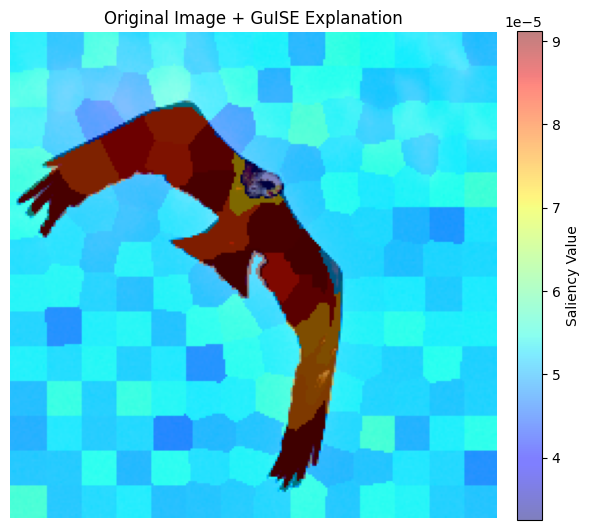

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert original image tensor to NumPy format.
# original_img is assumed to be a [C, H, W] tensor (float) in the appropriate range.
org_image_np = original_img.detach().cpu().numpy().squeeze()  # Shape: [C, H, W]
org_image_np = np.transpose(org_image_np, (1, 2, 0))  # Convert to [H, W, C]

# Convert saliency map from PyTorch tensor to NumPy.
# org_expl is assumed to be a [H, W] tensor.
saliency_np = org_expl.detach().cpu().numpy()

# Plot the original image with the saliency map overlay.
plt.figure(figsize=(6, 6))
plt.imshow(org_image_np)  # Original image
plt.imshow(saliency_np, cmap='jet', alpha=0.5)  # Overlay the saliency map
plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
plt.title("Original Image + GuISE Explanation")
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
def get_center_attack_matrix(x, y, r, org_expl, L):
    """
    Generates a center attack matrix based on the explanation map.

    Parameters:
        x (int): x-coordinate of the center.
        y (int): y-coordinate of the center.
        r (int): Radius for the attack.
        org_expl (torch.Tensor): Explanation map.
        L (int): Size of the matrix.

    Returns:
        np.ndarray: Attack matrix.
    """
    exp_list = org_expl.flatten().cpu().numpy()  # Convert to numpy for processing
    exp_list_sort_idx = np.argsort(exp_list)[::-1]  # Indices of sorted explanations
    exp_list_sort = exp_list[exp_list_sort_idx]  # Sorted explanations
    mtx = np.zeros((L, L))

    # Initialize dictionaries
    counter_dict = defaultdict(int)
    counter_dict_sum = defaultdict(int)

    # Compute distance-based counts
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            counter_dict[n1] += 1

    # Compute cumulative counts
    max_n1 = max(x - 1 + y - 1, y + L - x - 1, L - x + L - y, L - y - 1 + x)
    for i in range(max_n1):
        if i == 0:
            counter_dict_sum[i] = 1
        else:
            counter_dict_sum[i] = counter_dict[i] + counter_dict_sum[i - 1]

    # Fill the matrix
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x + 1) + np.abs(j - y + 1)
            idx = counter_dict_sum.get(n1 - 1, 0)
            if idx >= len(exp_list_sort):
                idx = len(exp_list_sort) - 1  # Cap index to the maximum available index

            if n1 == 0:
                mtx[i, j] = exp_list_sort[0]
            elif n1 == 1:
                mtx[i, j] = exp_list_sort[1]
            elif n1 < r:
                mtx[i, j] = exp_list_sort[idx]
            else:
                mtx[i, j] = -exp_list_sort[min(len(exp_list_sort) - 1, counter_dict_sum.get(max_n1 + 1, 0))]

    return mtx

In [ ]:
# Add a batch dimension
img_tensor = img_tensor.unsqueeze(0)

# Move to device
img_tensor = img_tensor.to(device)

# Ensure the model is on the same device as the input tensor
model = model.to(device)

# Make predictions
predictions = model(img_tensor)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  # Should print the class index
origin_prediction_class = prediction_class

# Convert the image to a numpy array for further processing
im2 = np.array(image)
im2 = im2.astype(np.float64)
im_orig = im2  # Now im_orig has the shape (224, 224, 3)
print('im2.shape:', im2.shape)

# Further processing
im = im_orig.astype(np.float32)
print('im:', im.shape, type(im))  # Should print the shape of the image, e.g., (224, 224, 3)
print('ori_image')

# Sorting the prediction values
value_sort = np.sort(predictions[0])[::-1]
print(value_sort[:2][0], value_sort[:2][1])
score_diff = value_sort[:2][0] - value_sort[:2][1]
print('dump score diff:', score_diff)

Prediction class: 21
im2.shape: (394, 500, 3)
im: (394, 500, 3) <class 'numpy.ndarray'>
ori_image
6.8708105 3.7052624
dump score diff: 3.165548


In [ ]:
import torch
from torchvision import transforms
import numpy as np

# Preprocessing without normalization
preprocess_1 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),          # Convert image to tensor
])

# Apply preprocessing
img_tensor_1 = preprocess_1(image).to(device).unsqueeze(0)  # Add batch dimension

# Assuming `predictions` is the output from the model (e.g., logits or probabilities)
# Get top-5 predictions
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]

# Display top-5 labels and scores
for i in range(5):
    print(f"Label: {index_sort[i]}, Score: {value_sort[i]:.4f}")


Label: 21, Score: 6.8708
Label: 146, Score: 3.7053
Label: 22, Score: 3.2884
Label: 23, Score: 1.7933
Label: 134, Score: 1.6087


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_iter = 100  # Number of iterations for the attack
prefactors = [0.01, 0.001]  # Weights for the loss terms
early_stop_epoch = 0
EARLY_STOP = True
learning_rate = 1e-4  # Learning rate for perturbations

# Initialize optimizer
x_adv = img_tensor.clone().detach().to(device).requires_grad_(True)
optimizer = torch.optim.Adam([x_adv], lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Instantiate the loss function
mse_loss = nn.MSELoss()

# Store results
total_loss_list = []
L1_score = []
L2_score = []
L3_score = []
L4_score = []
L5_score = []

In [ ]:
# Original prediction
output = model(img_tensor)
origin_prediction_class = output.argmax().item()

# Explanation for the original image using RISE
#org_masks = generate_masks(2000, 8, 0.5, model.input_size)
#explain(model, img_np, masks)
#org_expl = explain(model, img_np, masks)
#org_expl_torch = torch.tensor(org_expl).to(device).float()  # Convert to tensor for further use

In [ ]:
# Initialize target_mtx here
target_mtx = torch.zeros_like(org_expl)  # Create the target matrix
# Ensure target_mtx_torch and org_acc are defined correctly
target_mtx_torch = torch.zeros_like(img_tensor, requires_grad=True).to(device)

# target_mtx_torch = torch.zeros_like(img_tensor).to(device)  # Define as needed, should match `adv_expl` shape
print("Initial target_mtx_torch shape:", target_mtx_torch.shape)
# If target_mtx_torch is a single explanation map
# Adjust its shape to be compatible for loss calculation
# target_mtx_torch = target_mtx_torch.unsqueeze(0)  # Shape becomes [1, 3, 224, 224]
#target_mtx_torch = target_mtx_torch.repeat(x_adv.shape[0], 1, 1, 1)  # Expand to [N, 3, 224, 224]

org_acc = output.clone().detach()

Initial target_mtx_torch shape: torch.Size([1, 3, 224, 224])


In [ ]:
# Define attack and explanation loop
for i in range(num_iter):
    optimizer.zero_grad()  # Reset gradients

    # Forward pass for the adversarial image
    adv_output = model(x_adv)

    # Compute `adv_acc` for the adversarial output
    adv_acc = adv_output.clone().detach()

    # Compute explanation for the adversarial image using RISE
    #x_adv = x_adv.detach().cpu().numpy()
    adv_expl = explain(model, x_adv, masks)
    adv_expl_torch = torch.tensor(adv_expl).to(device).float()

    #print("adv_expl_torch requires_grad:", adv_expl_torch.requires_grad)
    #print("target_mtx_torch requires_grad:", target_mtx_torch.requires_grad)

    # Ensure target tensor is set correctly
    target_mtx_torch = target_mtx_torch.to(device)

    # Loss 1: MSE between the explanation maps (i.e., attacking the explanation)
    L1 = mse_loss(adv_expl_torch, target_mtx_torch)

    # Loss 2: Difference between original and adversarial outputs (to minimize classification accuracy)
    L2 = mse_loss(adv_acc[0][origin_prediction_class], org_acc[0][origin_prediction_class].detach())

    # Weighted sum of losses
    total_loss = prefactors[0] * L1 + prefactors[1] * L2
    total_loss_list.append(total_loss.item())

    # Backpropagation
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Obtain new predictions
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()

    # Update scores for top-5 classes
    index_sort = np.argsort(predictions[0])[::-1]
    L1_score.append(predictions[0][index_sort[0]])
    L2_score.append(predictions[0][index_sort[1]])
    L3_score.append(predictions[0][index_sort[2]])
    L4_score.append(predictions[0][index_sort[3]])
    L5_score.append(predictions[0][index_sort[4]])

    # Early stopping condition
    prediction_class_tmp = np.argmax(predictions[0])
    if i > 10 and origin_prediction_class != prediction_class_tmp:
        print(i, 'early done')
        early_stop_epoch = i
        if EARLY_STOP:
            x_adv = x_adv.clone().detach()
            break

    # Clamp the adversarial example
    x_adv.data = torch.clamp(x_adv.data, 0, 1)  # Ensure valid range [0, 1]

    # Debugging information
    if (i + 1) % 10 == 0 or i == 0:
        print(f"Iteration {i + 1}: Total Loss: {total_loss.item()}, Center Loss: {L1.item()}, Output Loss: {L2.item()}")


Explaining: 100%|██████████| 6/6 [00:00<00:00, 20.19it/s]
<ipython-input-40-dc21d7c189a4>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adv_expl_torch = torch.tensor(adv_expl).to(device).float()
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 3, 224, 224])) that is different to the input size (torch.Size([224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 1: Total Loss: 3.212941024344218e-11, Center Loss: 3.212941246388823e-09, Output Loss: 0.0


Explaining: 100%|██████████| 6/6 [00:00<00:00, 22.21it/s]


Iteration 10: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.66it/s]


Iteration 20: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.19it/s]


Iteration 30: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.13it/s]


Iteration 40: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 20.49it/s]


Iteration 50: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 20.26it/s]


Iteration 60: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.02it/s]


Iteration 70: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.57it/s]


Iteration 80: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.21it/s]


Iteration 90: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


Explaining: 100%|██████████| 6/6 [00:00<00:00, 21.54it/s]


Iteration 100: Total Loss: 0.0005847494467161596, Center Loss: 1.594780307812016e-08, Output Loss: 0.5847492218017578


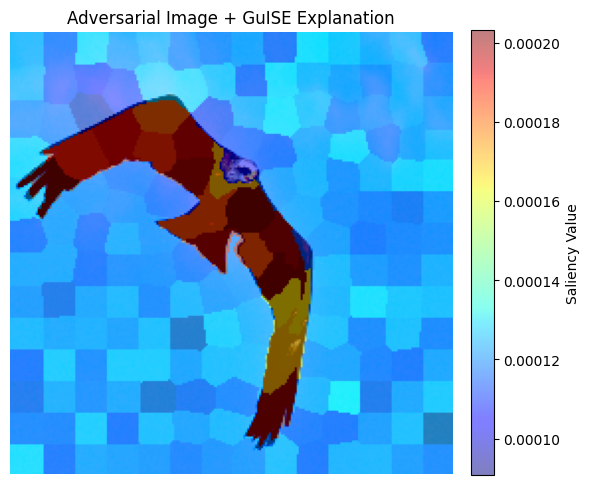

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Convert original image tensor to NumPy format.
# original_img is assumed to be a [C, H, W] tensor (float) in the appropriate range.
x_image_np = x_adv.detach().cpu().numpy().squeeze()  # Shape: [C, H, W]
adv_image_np = np.transpose(x_image_np, (1, 2, 0))  # Convert to [H, W, C]

# Convert saliency map from PyTorch tensor to NumPy.
# org_expl is assumed to be a [H, W] tensor.
saliency_np = org_expl.detach().cpu().numpy()

# Plot the original image with the saliency map overlay.
plt.figure(figsize=(6, 6))
plt.imshow(adv_image_np)  # Original image
plt.imshow(adv_expl.detach().cpu().numpy(), cmap='jet', alpha=0.5)  # Overlay the saliency map
plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
plt.title("Adversarial Image + GuISE Explanation")
plt.axis("off")
plt.tight_layout()
plt.show()


GINI Value

In [ ]:
def gini(array):
    array = np.array(array, dtype=np.float64)
    array = np.abs(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


In [ ]:
# computing GINI
from skimage import color
import numpy as np

GINI_list = []
ori_gini_list = []
adv_gini_list = []

# Ensure both org_expl and adv_expl are on CPU and detached, then convert to NumPy arrays.
img1_np = org_expl.detach().cpu().numpy()
img2_np = adv_expl.detach().cpu().numpy()

GINI_diff = np.abs(gini(img1_np.flatten()) - gini(img2_np.flatten()))
GINI_list.append(GINI_diff)
ori_gini_list.append(gini(img1_np.flatten()))
adv_gini_list.append(gini(img2_np.flatten()))


In [ ]:
print(GINI_list)
print(ori_gini_list)
print(adv_gini_list)

[np.float64(0.0003605122043388864)]
[np.float64(0.09762252137073266)]
[np.float64(0.09726200916639377)]


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Convert adversarial image to NumPy
# org_image_np = original_img.detach().cpu().numpy().squeeze()
# org_image_np = np.transpose(org_image_np, (1, 2, 0))
# #org_image_np = np.clip(adv_image_np * 255, 0, 255).astype(np.uint8)

# # Normalize saliency map for better contrast
# org_expl_np = org_expl_torch.detach().cpu().numpy()
# #org_expl_np = (org_expl_np - org_expl_np.min()) / (org_expl_np.max() - org_expl_np.min() + 1e-8)

# # Plot with overlay
# plt.figure(figsize=(6, 6))
# plt.imshow(org_image_np)
# plt.imshow(org_expl_np, cmap='seismic', alpha=0.5)
# plt.colorbar(label="Saliency Value", fraction=0.046, pad=0.04)
# plt.title("Original Image + GuISE Explanation")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


In [ ]:
 # Obtain new predictions
predict = model(img_tensor)
predict = predict.cpu().detach().numpy()

value_sort = np.sort(predict[0])[::-1]
index_sort = np.argsort(predict[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  339  score:  8.301613
label:  603  score:  3.4195716
label:  676  score:  2.0477505
label:  439  score:  2.047294
label:  912  score:  1.8797235


Graph

Label-98

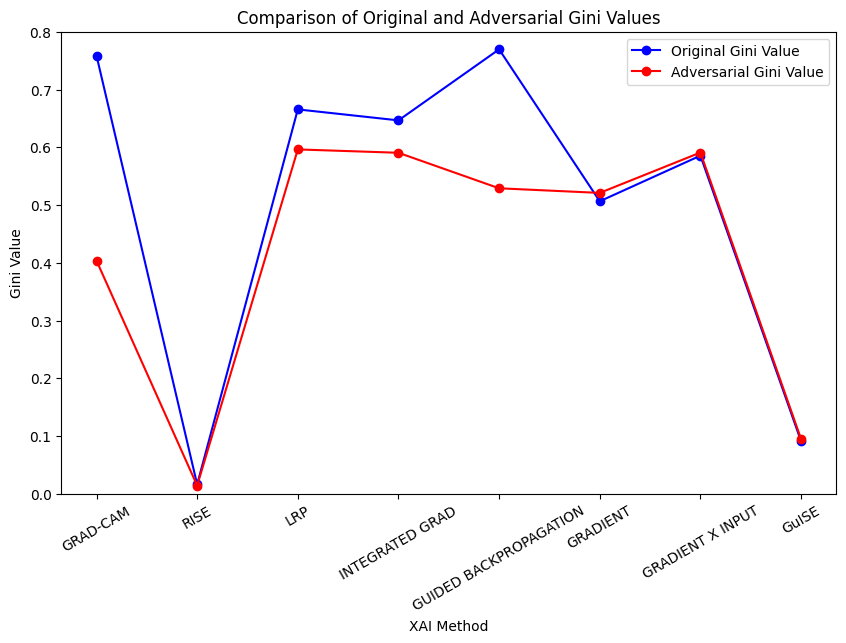

In [ ]:
import matplotlib.pyplot as plt

# XAI methods
xai_methods = ['GRAD-CAM', 'RISE', 'LRP', 'INTEGRATED GRAD',
               'GUIDED BACKPROPAGATION', 'GRADIENT', 'GRADIENT X INPUT','GuISE']

# Gini values
original_gini = [0.7587, 0.0162, 0.6656, 0.6466, 0.7696, 0.5065, 0.5855,0.0911]
adversarial_gini = [0.4037, 0.0142, 0.5963, 0.5905, 0.5290, 0.5210, 0.5909,0.0949]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(xai_methods, original_gini, marker='o', color='blue', label='Original Gini Value')
plt.plot(xai_methods, adversarial_gini, marker='o', color='red', label='Adversarial Gini Value')

# Labels and title
plt.title('Comparison of Original and Adversarial Gini Values')
plt.xlabel('XAI Method')
plt.ylabel('Gini Value')
plt.xticks(rotation=30)
plt.ylim(0, 0.8)
plt.legend()

# # Caption-like text
# plt.figtext(0.1, -0.05,
#             'Figure 3: Focus Shifting attack: Gini Value Graph Representation of Label-98 (Imagenet Dataset)',
#             fontsize=10, fontweight='bold', ha='left')

# plt.tight_layout()
plt.show()


Label-339

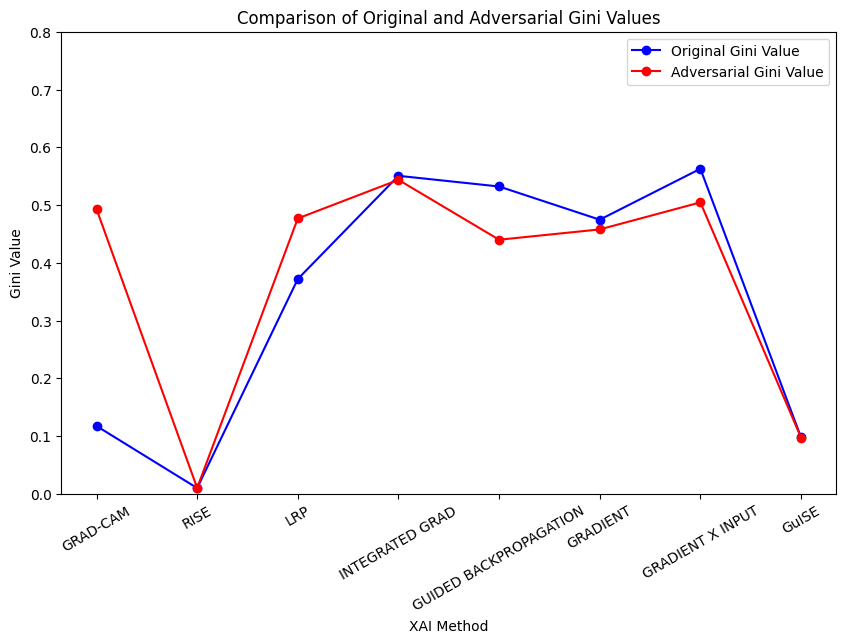

In [ ]:
import matplotlib.pyplot as plt

# XAI methods
xai_methods = ['GRAD-CAM', 'RISE', 'LRP', 'INTEGRATED GRAD',
               'GUIDED BACKPROPAGATION', 'GRADIENT', 'GRADIENT X INPUT','GuISE']

# Gini values
original_gini = [0.1174, 0.0099, 0.3719, 0.5506, 0.5321, 0.4746, 0.5628,0.0976]
adversarial_gini = [0.4930, 0.0101, 0.4768, 0.5436, 0.4399, 0.4578, 0.5046,0.0972]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(xai_methods, original_gini, marker='o', color='blue', label='Original Gini Value')
plt.plot(xai_methods, adversarial_gini, marker='o', color='red', label='Adversarial Gini Value')

# Labels and title
plt.title('Comparison of Original and Adversarial Gini Values')
plt.xlabel('XAI Method')
plt.ylabel('Gini Value')
plt.xticks(rotation=30)
plt.ylim(0, 0.8)
plt.legend()

# # Caption-like text
# plt.figtext(0.1, -0.05,
#             'Figure 3: Focus Shifting attack: Gini Value Graph Representation of Label-98 (Imagenet Dataset)',
#             fontsize=10, fontweight='bold', ha='left')

# plt.tight_layout()
plt.show()


Target Atk graph

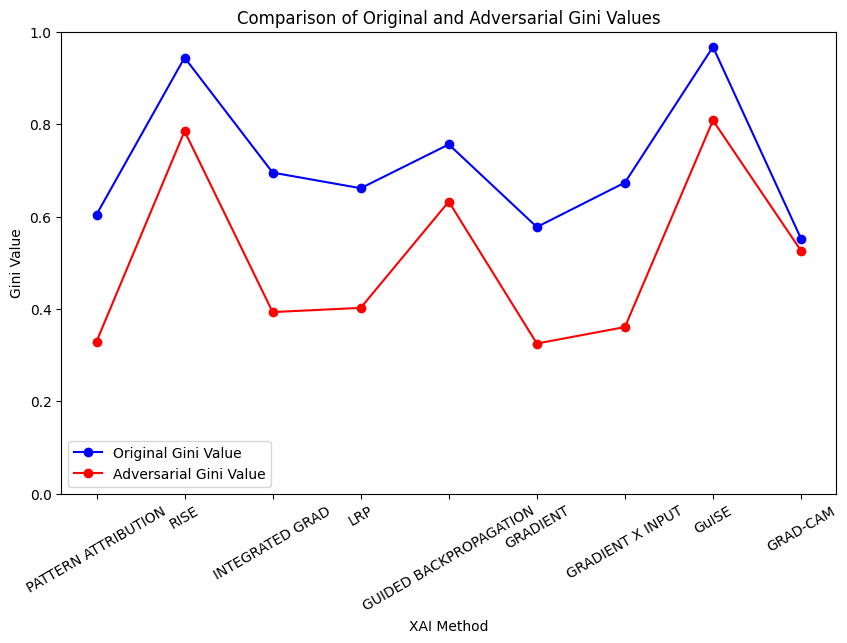

In [ ]:
import matplotlib.pyplot as plt

# XAI methods
xai_methods = ['PATTERN ATTRIBUTION', 'RISE', 'INTEGRATED GRAD', 'LRP',
               'GUIDED BACKPROPAGATION', 'GRADIENT', 'GRADIENT X INPUT','GuISE','GRAD-CAM']

# Gini values
original_gini = [0.6043,0.9441 ,0.6952, 0.6614, 0.7562, 0.5774, 0.6736,0.9673 ,0.5520]
adversarial_gini = [0.3295,0.7849 , 0.3933,0.4024,0.6324,0.3252,0.3609,0.8081 ,0.5260]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(xai_methods, original_gini, marker='o', color='blue', label='Original Gini Value')
plt.plot(xai_methods, adversarial_gini, marker='o', color='red', label='Adversarial Gini Value')

# Labels and title
plt.title('Comparison of Original and Adversarial Gini Values')
plt.xlabel('XAI Method')
plt.ylabel('Gini Value')
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.legend()

# # Caption-like text
# plt.figtext(0.1, -0.05,
#             'Figure 3: Focus Shifting attack: Gini Value Graph Representation of Label-98 (Imagenet Dataset)',
#             fontsize=10, fontweight='bold', ha='left')

# plt.tight_layout()
plt.show()


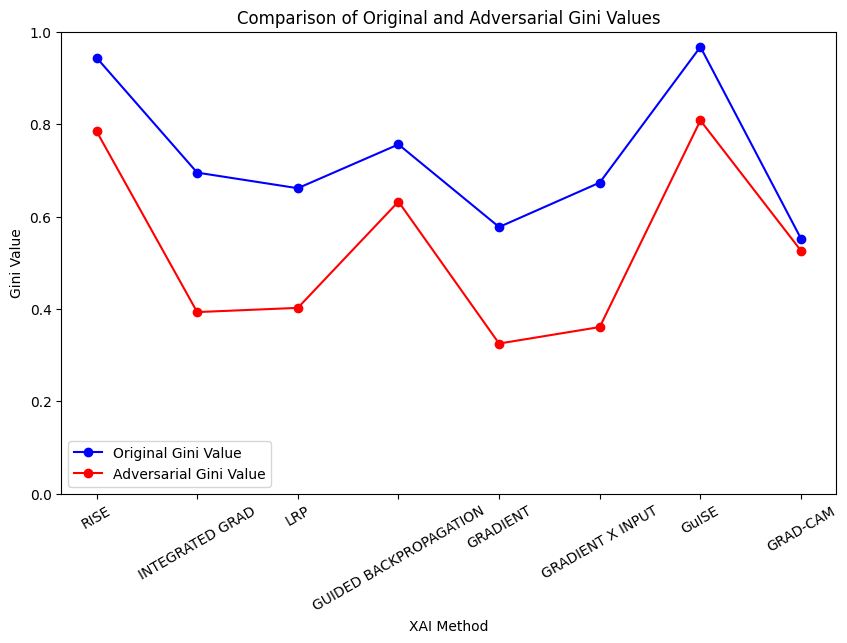

In [ ]:
import matplotlib.pyplot as plt

# XAI methods
xai_methods = ['RISE', 'INTEGRATED GRAD', 'LRP',
               'GUIDED BACKPROPAGATION', 'GRADIENT', 'GRADIENT X INPUT','GuISE','GRAD-CAM']

# Gini values
original_gini = [0.9441 ,0.6952, 0.6614, 0.7562, 0.5774, 0.6736,0.9673 ,0.5520]
adversarial_gini = [0.7849 , 0.3933,0.4024,0.6324,0.3252,0.3609,0.8081 ,0.5260]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(xai_methods, original_gini, marker='o', color='blue', label='Original Gini Value')
plt.plot(xai_methods, adversarial_gini, marker='o', color='red', label='Adversarial Gini Value')

# Labels and title
plt.title('Comparison of Original and Adversarial Gini Values')
plt.xlabel('XAI Method')
plt.ylabel('Gini Value')
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.legend()

# # Caption-like text
# plt.figtext(0.1, -0.05,
#             'Figure 3: Focus Shifting attack: Gini Value Graph Representation of Label-98 (Imagenet Dataset)',
#             fontsize=10, fontweight='bold', ha='left')

# plt.tight_layout()
plt.show()
